![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [1]:
# Research notebook for random forest algorithm
# Adapted from Jansen 2020 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from talib import RSI, BBANDS, MACD, NATR, ATR, PPO 
from scipy.stats import spearmanr, norm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from AlgorithmImports import *
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

idx = pd.IndexSlice
qb = QuantBook()

In [3]:
symbols = {}
assets = ["SHY", "TLT", "SHV", "TLH", "EDV", "BIL",
          "SPTL", "TBT", "TMF", "TMV", "TBF", "VGSH", "VGIT",
          "VGLT", "SCHO", "SCHR", "SPTS", "GOVT", 'SPY']

for i in range(len(assets)):
    symbols[assets[i]] = qb.AddEquity(assets[i],Resolution.Minute).Symbol

qb.SetStartDate(2013, 1, 1)

# qb.AddUniverse(CoarseSelectionFunction, FineSelectionFunction)
df = qb.History(qb.Securities.Keys, 2*360, resolution=Resolution.Daily)
df.dropna(inplace=True)

df.head()

close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2010-02-24  73.144832  73.171102  73.109805  73.127319   
                 2010-02-25  73.179859  73.197372  73.127319  73.136075   
                 2010-02-26  73.241156  73.258669  73.214886  73.241156   
                 2010-02-27  73.267426  73.284939  73.223642  73.223642   
                 2010-03-02  73.254276  73.280570  73.227982  73.245511   

                                volume  
symbol           time                   
SHY SGNKIKYGE9NP 2010-02-24   935580.0  
                 2010-02-25  1205229.0  
                 2010-02-26   820380.0  
                 2010-02-27  1024528.0  
                 2010-03-02   959268.0

### Create Features

In [4]:
# calculate returns
intervals = [1, 5, 10, 21, 63]
returns = []
by_symbol = df.groupby('symbol', group_keys=False)
for t in intervals:
    returns.append(by_symbol.close.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)
df1 = df 
df = pd.merge(df1, returns, on=('symbol', 'time'))
returns.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12495 entries, ('SHY SGNKIKYGE9NP', Timestamp('2010-02-24 00:00:00')) to ('GOVT V45XL2BVKU3P', Timestamp('2013-01-01 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_1   12476 non-null  float64
 1   ret_5   12400 non-null  float64
 2   ret_10  12305 non-null  float64
 3   ret_21  12096 non-null  float64
 4   ret_63  11298 non-null  float64
dtypes: float64(5)
memory usage: 547.3+ KB


close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2010-02-24  73.144832  73.171102  73.109805  73.127319   
                 2010-02-25  73.179859  73.197372  73.127319  73.136075   
                 2010-02-26  73.241156  73.258669  73.214886  73.241156   
                 2010-02-27  73.267426  73.284939  73.223642  73.223642   
                 2010-03-02  73.254276  73.280570  73.227982  73.245511   

                                volume     ret_1  ret_5  ret_10  ret_21  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2010-02-24   935580.0       NaN    NaN     NaN     NaN   
                 2010-02-25  1205229.0  0.000479    NaN     NaN     NaN   
                 2010-02-26   820380.0  0.000838    NaN     NaN     NaN   
                 2010-02-27  1024528.0  0.000359    NaN     NaN     NaN   
                 2010-03-02   959268.0 -0.000179    NaN     NaN     NaN   

                             ret_63  
symbol           time                
SHY SGNKIKYGE9NP 2010-02-24     NaN  
                 2010-02-25     NaN  
                 2010-02-26     NaN  
                 2010-02-27     NaN  
                 2010-03-02     NaN

In [5]:
by_symbol = df.groupby('symbol', group_keys=False)
# compute RSI 
df['rsi'] = df.groupby('symbol').close.apply(RSI)
df['ppo'] = df.groupby('symbol').close.apply(PPO)
df.head()

close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2010-02-24  73.144832  73.171102  73.109805  73.127319   
                 2010-02-25  73.179859  73.197372  73.127319  73.136075   
                 2010-02-26  73.241156  73.258669  73.214886  73.241156   
                 2010-02-27  73.267426  73.284939  73.223642  73.223642   
                 2010-03-02  73.254276  73.280570  73.227982  73.245511   

                                volume     ret_1  ret_5  ret_10  ret_21  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2010-02-24   935580.0       NaN    NaN     NaN     NaN   
                 2010-02-25  1205229.0  0.000479    NaN     NaN     NaN   
                 2010-02-26   820380.0  0.000838    NaN     NaN     NaN   
                 2010-02-27  1024528.0  0.000359    NaN     NaN     NaN   
                 2010-03-02   959268.0 -0.000179    NaN     NaN     NaN   

                             ret_63  rsi  ppo  
symbol           time                          
SHY SGNKIKYGE9NP 2010-02-24     NaN  NaN  NaN  
                 2010-02-25     NaN  NaN  NaN  
                 2010-02-26     NaN  NaN  NaN  
                 2010-02-27     NaN  NaN  NaN  
                 2010-03-02     NaN  NaN  NaN

In [6]:
# compute bollenger bands
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_mid': mid, 'bb_low': low}, index=close.index)
bb_df = df.groupby('symbol').close.apply(compute_bb)
bb_df.head() 

bb_high  bb_mid  bb_low
symbol           time                               
SHY SGNKIKYGE9NP 2010-02-24      NaN     NaN     NaN
                 2010-02-25      NaN     NaN     NaN
                 2010-02-26      NaN     NaN     NaN
                 2010-02-27      NaN     NaN     NaN
                 2010-03-02      NaN     NaN     NaN

In [7]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, stock_data.low, stock_data.close, timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())
atr_series = by_symbol.apply(compute_atr)
df['atr'] = atr_series.to_frame().drop_duplicates()
df.head()

close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2010-02-24  73.144832  73.171102  73.109805  73.127319   
                 2010-02-25  73.179859  73.197372  73.127319  73.136075   
                 2010-02-26  73.241156  73.258669  73.214886  73.241156   
                 2010-02-27  73.267426  73.284939  73.223642  73.223642   
                 2010-03-02  73.254276  73.280570  73.227982  73.245511   

                                volume     ret_1  ret_5  ret_10  ret_21  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2010-02-24   935580.0       NaN    NaN     NaN     NaN   
                 2010-02-25  1205229.0  0.000479    NaN     NaN     NaN   
                 2010-02-26   820380.0  0.000838    NaN     NaN     NaN   
                 2010-02-27  1024528.0  0.000359    NaN     NaN     NaN   
                 2010-03-02   959268.0 -0.000179    NaN     NaN     NaN   

                             ret_63  rsi  ppo  atr  
symbol           time                               
SHY SGNKIKYGE9NP 2010-02-24     NaN  NaN  NaN  NaN  
                 2010-02-25     NaN  NaN  NaN  NaN  
                 2010-02-26     NaN  NaN  NaN  NaN  
                 2010-02-27     NaN  NaN  NaN  NaN  
                 2010-03-02     NaN  NaN  NaN  NaN

In [8]:
natr_series = by_symbol.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))
df['natr'] = natr_series.to_frame().drop_duplicates()

In [9]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

macd_series = df.groupby(level='symbol').close.apply(compute_macd)
df['macd'] = macd_series.to_frame().drop_duplicates() 

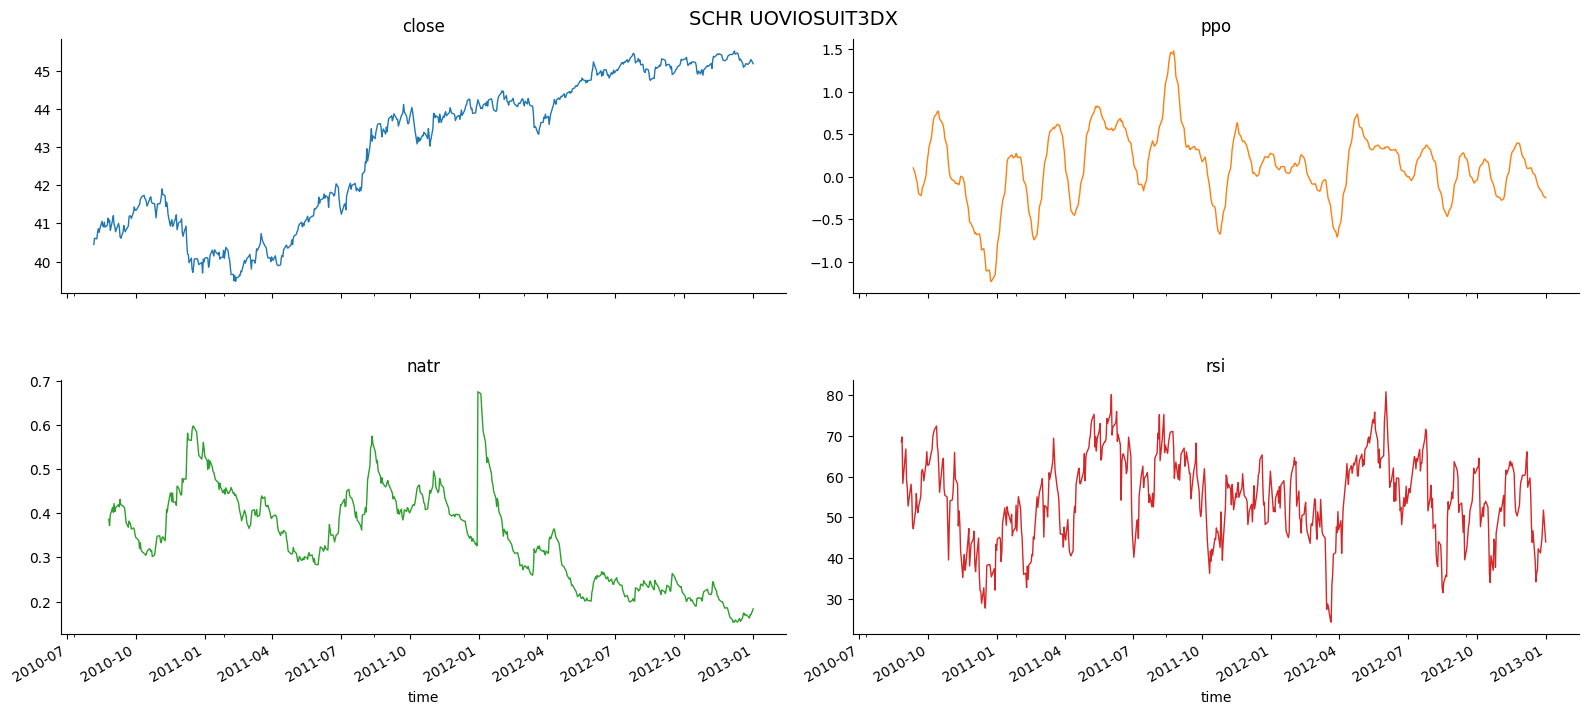

In [10]:
indicators = ['close', 'ppo', 'natr',  'rsi']
ticker = np.random.choice(df.index.get_level_values('symbol'))
(df.loc[idx[ticker, :], indicators].reset_index('symbol', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)

In [11]:
outcomes = []
by_ticker = df.groupby('symbol')
for t in intervals:
    k = f'fwd_ret_{t}'
    outcomes.append(k)
    df[k] = by_ticker[f'ret_{t}'].shift(-t)
df.head(10)

close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2010-02-24  73.144832  73.171102  73.109805  73.127319   
                 2010-02-25  73.179859  73.197372  73.127319  73.136075   
                 2010-02-26  73.241156  73.258669  73.214886  73.241156   
                 2010-02-27  73.267426  73.284939  73.223642  73.223642   
                 2010-03-02  73.254276  73.280570  73.227982  73.245511   
                 2010-03-03  73.254276  73.280570  73.236747  73.236747   
                 2010-03-04  73.263041  73.280570  73.210453  73.236747   
                 2010-03-05  73.210453  73.254276  73.184160  73.201689   
                 2010-03-06  73.149101  73.166630  73.096514  73.149101   
                 2010-03-09  73.122808  73.140337  73.114043  73.122808   

                                volume     ret_1     ret_5  ret_10  ret_21  \
symbol           time                                                        
SHY SGNKIKYGE9NP 2010-02-24   935580.0       NaN       NaN     NaN     NaN   
                 2010-02-25  1205229.0  0.000479       NaN     NaN     NaN   
                 2010-02-26   820380.0  0.000838       NaN     NaN     NaN   
                 2010-02-27  1024528.0  0.000359       NaN     NaN     NaN   
                 2010-03-02   959268.0 -0.000179       NaN     NaN     NaN   
                 2010-03-03  1260530.0  0.000000  0.001496     NaN     NaN   
                 2010-03-04  1248939.0  0.000120  0.001137     NaN     NaN   
                 2010-03-05   922739.0 -0.000718 -0.000419     NaN     NaN   
                 2010-03-06  1267590.0 -0.000838 -0.001615     NaN     NaN   
                 2010-03-09  1059100.0 -0.000359 -0.001795     NaN     NaN   

                             ret_63  rsi  ppo  atr  natr  macd  fwd_ret_1  \
symbol           time                                                       
SHY SGNKIKYGE9NP 2010-02-24     NaN  NaN  NaN  NaN   NaN   NaN   0.000479   
                 2010-02-25     NaN  NaN  NaN  NaN   NaN   NaN   0.000838   
                 2010-02-26     NaN  NaN  NaN  NaN   NaN   NaN   0.000359   
                 2010-02-27     NaN  NaN  NaN  NaN   NaN   NaN  -0.000179   
                 2010-03-02     NaN  NaN  NaN  NaN   NaN   NaN   0.000000   
                 2010-03-03     NaN  NaN  NaN  NaN   NaN   NaN   0.000120   
                 2010-03-04     NaN  NaN  NaN  NaN   NaN   NaN  -0.000718   
                 2010-03-05     NaN  NaN  NaN  NaN   NaN   NaN  -0.000838   
                 2010-03-06     NaN  NaN  NaN  NaN   NaN   NaN  -0.000359   
                 2010-03-09     NaN  NaN  NaN  NaN   NaN   NaN   0.000839   

                             fwd_ret_5  fwd_ret_10  fwd_ret_21  fwd_ret_63  
symbol           time                                                       
SHY SGNKIKYGE9NP 2010-02-24   0.001496    0.000538   -0.002937    0.006156  
                 2010-02-25   0.001137   -0.000301   -0.003295    0.005675  
                 2010-02-26  -0.000419   -0.002214   -0.003411    0.003994  
                 2010-02-27  -0.001615   -0.002572   -0.003170    0.002795  
                 2010-03-02  -0.001795   -0.002034   -0.003470    0.005132  
                 2010-03-03  -0.000957   -0.001795   -0.002273    0.005024  
                 2010-03-04  -0.001436   -0.001675   -0.003111    0.004184  
                 2010-03-05  -0.001796   -0.001556   -0.005031    0.004906  
                 2010-03-06  -0.000959   -0.001558   -0.003477    0.007791  
                 2010-03-09  -0.000240   -0.000719   -0.001799    0.007913

### Training Model

In [13]:
from rf_utils import *
cv = MultipleTimeSeriesCV(n_splits=36, test_period_length=21, lookahead=5, train_period_length= 2 * 252)

ModuleNotFoundError: No module named 'rf_utils'

In [ ]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=df)):
    train = df.iloc[train_idx]
    train_times = train.index.get_level_values('time')
    test = df.iloc[test_idx]
    test_times = test.index.get_level_values('time')
    df1 = train.reset_index().append(test.reset_index())
    n = len(df1)
    assert n== len(df1.drop_duplicates())
    msg = f'Training: {train_times.min().date()}-{train_times.max().date()} '
    msg += f' ({train.groupby(level="symbol").size().value_counts().index[0]:,.0f} days) | '
    msg += f'Test: {test_times.min().time()}-{test_times.max().date()} '
    msg += f'({test.groupby(level="symbol").size().value_counts().index[0]:,.0f} days)'
    print(msg)
    if i == 3:
        break

KeyError: 'Level date not found'